In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import gc
import sys
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from pylab import rcParams


rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Impago"]

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
                # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)     
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [6]:
#1- Cargo fichero bureau_balance.csv y veo cabecera 
BureauBalance = pd.read_csv('/Users/LENOVO/Downloads/bureau_balance.csv', delimiter= ',' , header=0)
#BureauBalance.head()
#BureauBalance.describe()
BureauBalance = BureauBalance.dropna()
BureauBalance


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [7]:
BureauBalance.dtypes.value_counts()

int64     2
object    1
dtype: int64

In [8]:
#Función cuenta variables categoricas
def count_categoricas(df, group_var, df_name):
    """Calcula conteos y conteos normalizados para cada observación
    de `group_var` de cada categoría única en cada variable categórica
    
    Parámetros
    --------
    df : dataframe 
         El marco de datos para calcular el valor cuenta.
        
    group_var : string
        La variable por la cual agrupar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
        Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con recuentos y recuentos normalizados de cada categoría única en cada variable categórica
        con una fila por cada valor único de `group_var`
        
    """
    
    #Seleccion de las columnas categóricas
    categorica = pd.get_dummies(df.select_dtypes('object'))

    # Pone la de identificación en la columna
    categorica[group_var] = df[group_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorica = categorica.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    # Itera a través de las columnas en el nivel 0
    for var in categorica.columns.levels[0]:
        # Iterar a través de las estadísticas en el nivel 1
        for stat in ['count', 'count_norm']:
            # Genera un nuevo nombre de columna
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorica.columns = column_names
    
    return categorica

In [9]:
#Función cuenta variables numéricas
def agg_numericas(df, group_var, df_name):
    """Agrega los valores numéricos en un marco de datos. Esto puede
    se utilizará para crear características para cada instancia de la variable de agrupación.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos para calcular las estadísticas
        group_var (string): 
            la variable por la cual agrupar df
        df_name (string):            
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas para
            Todas las columnas numéricas. Cada instancia de la variable de agrupación tendrá
            las estadísticas (media, min, max, suma; actualmente admitidas) calculadas.
            Las columnas también se renombran para realizar un seguimiento de las características creadas.
    
    """
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

   #Crea nuevos nombres de columna
    columns = [group_var]

   #Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        # Salta la variable de agrupación
        if var != group_var:
            #Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1][:-1]:
                # Hace un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [10]:
#Recuento de cada tipo de estado de las variables CATEGORICAS para cada préstamo anterior por campo 'SK_ID_BUREAU'
BureauBalance_counts = count_categoricas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_counts.head()
#BureauBalance_counts.describe()
BureauBalance_counts


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842884,9,0.187500,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833
6842885,12,0.500000,0,0.000000,0,0.0,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000
6842886,8,0.242424,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000


In [11]:
# Calculo estadísticas de recuento de variables NUMERICAS para cada 'SK_ID_BUREAU' 
BureauBalance_agg = agg_numericas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_agg.head()
#BureauBalance_agg.describe()
BureauBalance_agg


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231
...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128
817391,6842885,24,-11.5,0,-23,-276
817392,6842886,33,-16.0,0,-32,-528
817393,6842887,37,-18.0,0,-36,-666


In [12]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
BureauBalance_by_loan = BureauBalance_agg.merge(BureauBalance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
#BureauBalance_by_loan.head()
#BureauBalance_by_loan.describe()
BureauBalance_by_loan

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.000000,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.000000,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.000000,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128,9,0.187500,0,0.000000,...,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833
817391,6842885,24,-11.5,0,-23,-276,12,0.500000,0,0.000000,...,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000
817392,6842886,33,-16.0,0,-32,-528,8,0.242424,0,0.000000,...,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000
817393,6842887,37,-18.0,0,-36,-666,6,0.162162,0,0.000000,...,0,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000


In [13]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [14]:
#2- Cargo fichero bureau.csv
Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#Bureau.head()
#Bureau.describe()
Bureau = Bureau.dropna()
Bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
822,298038,5715510,Closed,currency 1,-586,0,-339.0,-553.0,0.000,0,40791.330,0.0,0.0,0.0,Consumer credit,-553,67995.000
846,200527,5715537,Closed,currency 1,-824,0,-521.0,-581.0,0.000,0,89415.000,0.0,0.0,0.0,Consumer credit,-580,8245.395
849,393321,5715540,Closed,currency 1,-146,0,935.0,-41.0,0.000,0,445262.940,0.0,0.0,0.0,Consumer credit,-35,12162.150
896,296586,5715600,Closed,currency 1,-359,0,-55.0,-55.0,0.000,0,77239.035,0.0,0.0,0.0,Consumer credit,-50,0.000
902,190334,5715607,Closed,currency 1,-2320,0,-1953.0,-1953.0,0.000,0,64851.750,0.0,0.0,0.0,Consumer credit,-1155,16200.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716121,366608,5047705,Closed,currency 1,-2504,0,-2199.0,-2199.0,0.000,0,87862.500,0.0,0.0,0.0,Consumer credit,-2199,30600.000
1716126,217655,5047824,Closed,currency 1,-1050,0,-684.0,-684.0,0.000,0,55521.000,0.0,0.0,0.0,Consumer credit,-682,0.000
1716275,129052,5053577,Closed,currency 1,-2870,0,-2564.0,-2564.0,1611.045,0,15705.000,0.0,0.0,0.0,Consumer credit,-2557,43735.500
1716285,435426,5053678,Closed,currency 1,-1147,0,-416.0,-849.0,0.000,0,205488.000,0.0,0.0,0.0,Consumer credit,-835,94378.500


In [15]:
# Fusion para incluir la SK_ID_CURR
BureauBalance_by_loanMerge = BureauBalance_by_loan.merge(Bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
#BureauBalance_by_loanMerge
BureauBalance_by_loanMerge.head()


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,NaN
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,NaN
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,NaN
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,NaN


In [16]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_BUREAU'. Para unir a train****
BureauBalance_by_client = agg_numericas(BureauBalance_by_loanMerge.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
#BureauBalance_by_client.head()
#BureauBalance_by_client.describe()
BureauBalance_by_client

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100002.0,2,10.000000,16,4,20,2,-29.500000,-19.5,-39.5,...,2,1.500000,3,0,3,2,0.093750,0.187500,0.000000,0.187500
1,100032.0,1,19.000000,19,19,19,1,-36.000000,-36.0,-36.0,...,1,2.000000,2,2,2,1,0.105263,0.105263,0.105263,0.105263
2,100037.0,2,66.000000,66,66,132,2,-51.500000,-45.5,-57.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.000000,0.000000
3,100043.0,1,2.000000,2,2,2,1,-85.500000,-85.5,-85.5,...,1,1.000000,1,1,1,1,0.500000,0.500000,0.500000,0.500000
4,100059.0,2,11.500000,16,7,23,2,-19.750000,-3.0,-36.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,456219.0,1,8.000000,8,8,8,1,-3.500000,-3.5,-3.5,...,1,0.000000,0,0,0,1,0.000000,0.000000,0.000000,0.000000
24983,456234.0,2,15.500000,16,15,31,2,-17.750000,-7.0,-28.5,...,2,1.000000,1,1,2,2,0.064583,0.066667,0.062500,0.129167
24984,456238.0,1,88.000000,88,88,88,1,-43.500000,-43.5,-43.5,...,1,0.000000,0,0,0,1,0.000000,0.000000,0.000000,0.000000
24985,456244.0,3,40.333333,57,14,121,3,-19.666667,-6.5,-28.0,...,3,1.666667,2,1,5,3,0.066800,0.142857,0.017544,0.200401


In [17]:
BureauBalance_by_client.dtypes.value_counts()

float64    50
int64      33
uint8      23
dtype: int64

In [18]:
# Missing values statistics
missing_values = missing_values_table(BureauBalance_by_client)
missing_values.head(20)

Your selected dataframe has 106 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [19]:
corrs = BureauBalance_by_client.corr()
corrs

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
SK_ID_CURR,1.000000,0.000336,-0.002815,-0.000471,-0.004986,0.003833,0.000336,-0.000453,-0.000179,0.000307,...,0.000336,-0.002125,-0.000641,-0.003291,0.000130,0.000336,0.001401,0.001846,0.000142,0.000943
client_bureau_balance_MONTHS_BALANCE_count_count,0.000336,1.000000,-0.072102,0.110995,-0.239348,0.568209,1.000000,-0.069254,0.218794,-0.334770,...,1.000000,-0.023153,0.094947,-0.126702,0.228203,1.000000,0.000954,0.158431,-0.136974,0.396473
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.002815,-0.072102,1.000000,0.942348,0.943167,0.658577,-0.072102,-0.209471,-0.237589,-0.153336,...,-0.072102,0.290152,0.274715,0.268854,0.236621,-0.072102,-0.098040,-0.083475,-0.100552,-0.100717
client_bureau_balance_MONTHS_BALANCE_count_max,-0.000471,0.110995,0.942348,1.000000,0.785968,0.791904,0.110995,-0.199244,-0.157171,-0.212576,...,0.110995,0.279405,0.316171,0.209416,0.300925,0.110995,-0.085117,-0.017562,-0.139706,-0.017860
client_bureau_balance_MONTHS_BALANCE_count_min,-0.004986,-0.239348,0.943167,0.785968,1.000000,0.447318,-0.239348,-0.196835,-0.292366,-0.079827,...,-0.239348,0.268735,0.205212,0.299261,0.147777,-0.239348,-0.099013,-0.138326,-0.050166,-0.165601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_bureau_balance_STATUS_X_count_norm_count,0.000336,1.000000,-0.072102,0.110995,-0.239348,0.568209,1.000000,-0.069254,0.218794,-0.334770,...,1.000000,-0.023153,0.094947,-0.126702,0.228203,1.000000,0.000954,0.158431,-0.136974,0.396473
client_bureau_balance_STATUS_X_count_norm_mean,0.001401,0.000954,-0.098040,-0.085117,-0.099013,-0.068454,0.000954,-0.018451,-0.016750,-0.017344,...,0.000954,0.716169,0.670242,0.670067,0.625912,0.000954,1.000000,0.936513,0.935938,0.778823
client_bureau_balance_STATUS_X_count_norm_max,0.001846,0.158431,-0.083475,-0.017562,-0.138326,0.063442,0.158431,-0.009621,0.041315,-0.060412,...,0.158431,0.677920,0.722429,0.551844,0.691074,0.158431,0.936513,1.000000,0.766662,0.842542
client_bureau_balance_STATUS_X_count_norm_min,0.000142,-0.136974,-0.100552,-0.139706,-0.050166,-0.176060,-0.136974,-0.025565,-0.071986,0.023814,...,-0.136974,0.662171,0.535972,0.713197,0.472193,-0.136974,0.935938,0.766662,1.000000,0.607538


In [20]:
corrs = corrs.sort_values('client_bureau_balance_MONTHS_BALANCE_count_mean', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_bureau_balance_MONTHS_BALANCE_count_mean'].head(10))

,client_bureau_balance_MONTHS_BALANCE_count_mean
client_bureau_balance_MONTHS_BALANCE_count_mean,1.000000
client_bureau_balance_MONTHS_BALANCE_count_min,0.943167
client_bureau_balance_MONTHS_BALANCE_count_max,0.942348
client_bureau_balance_STATUS_C_count_mean,0.810482
client_bureau_balance_STATUS_C_count_max,0.764127
client_bureau_balance_STATUS_C_count_min,0.756240
client_bureau_balance_MONTHS_BALANCE_count_sum,0.658577
client_bureau_balance_STATUS_C_count_sum,0.638910
client_bureau_balance_STATUS_C_count_norm_mean,0.503272
client_bureau_balance_STATUS_C_count_norm_min,0.474363


In [21]:
#2- Cargo fichero bureau.csv
#Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#Bureau = Bureau.dropna()
#Bureau
Bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
822,298038,5715510,Closed,currency 1,-586,0,-339.0,-553.0,0.000,0,40791.330,0.0,0.0,0.0,Consumer credit,-553,67995.000
846,200527,5715537,Closed,currency 1,-824,0,-521.0,-581.0,0.000,0,89415.000,0.0,0.0,0.0,Consumer credit,-580,8245.395
849,393321,5715540,Closed,currency 1,-146,0,935.0,-41.0,0.000,0,445262.940,0.0,0.0,0.0,Consumer credit,-35,12162.150
896,296586,5715600,Closed,currency 1,-359,0,-55.0,-55.0,0.000,0,77239.035,0.0,0.0,0.0,Consumer credit,-50,0.000
902,190334,5715607,Closed,currency 1,-2320,0,-1953.0,-1953.0,0.000,0,64851.750,0.0,0.0,0.0,Consumer credit,-1155,16200.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716121,366608,5047705,Closed,currency 1,-2504,0,-2199.0,-2199.0,0.000,0,87862.500,0.0,0.0,0.0,Consumer credit,-2199,30600.000
1716126,217655,5047824,Closed,currency 1,-1050,0,-684.0,-684.0,0.000,0,55521.000,0.0,0.0,0.0,Consumer credit,-682,0.000
1716275,129052,5053577,Closed,currency 1,-2870,0,-2564.0,-2564.0,1611.045,0,15705.000,0.0,0.0,0.0,Consumer credit,-2557,43735.500
1716285,435426,5053678,Closed,currency 1,-1147,0,-416.0,-849.0,0.000,0,205488.000,0.0,0.0,0.0,Consumer credit,-835,94378.500


In [22]:
#Se cuentan los prestamos anteriores por campo SK_ID_BUREAU y se agrupan por 'SK_ID_CURR'
Previous_loan_counts = Bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
Previous_loan_counts

,SK_ID_CURR,previous_loan_counts
0,100002,2
1,100032,1
2,100037,2
3,100043,1
4,100059,2
...,...,...
24985,456219,1
24986,456234,2
24987,456238,1
24988,456244,3


In [23]:
#Genera recuento y estadisticas de las variables para cada préstamo anterior eliminando columna 'SK_ID_BUREAU'y
#agrupando por campo 'SK_ID_CURR'
Bureau_agg = Bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR',
as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() 
#Bureau_agg.head()
Bureau_agg

SK_ID_CURR DAYS_CREDIT                                 \
                       count         mean   max   min   sum   
0         100002           2 -1041.000000  -645 -1437 -2082   
1         100032           1 -1388.000000 -1388 -1388 -1388   
2         100037           2 -2570.000000 -2379 -2761 -5140   
3         100043           1 -2639.000000 -2639 -2639 -2639   
4         100059           2  -768.500000  -194 -1343 -1537   
...          ...         ...          ...   ...   ...   ...   
24985     456219           1  -227.000000  -227  -227  -227   
24986     456234           2  -778.000000  -438 -1118 -1556   
24987     456238           1 -2665.000000 -2665 -2665 -2665   
24988     456244           3 -1205.333333  -400 -1719 -3616   
24989     456247           1  -776.000000  -776  -776  -776   

      CREDIT_DAY_OVERDUE               ... DAYS_CREDIT_UPDATE               \
                   count mean max min  ...              count         mean   
0                      2    0   0   0  ...                  2  -609.500000   
1                      1    0   0   0  ...                  1  -456.000000   
2                      2    0   0   0  ...                  2 -2439.500000   
3                      1    0   0   0  ...                  1 -2513.000000   
4                      2    0   0   0  ...                  2  -371.000000   
...                  ...  ...  ..  ..  ...                ...          ...   
24985                  1    0   0   0  ...                  1   -10.000000   
24986                  2    0   0   0  ...                  2  -681.000000   
24987                  1    0   0   0  ...                  1 -2602.000000   
24988                  3    0   0   0  ...                  3 -1056.666667   
24989                  1    0   0   0  ...                  1  -500.000000   

                        AMT_ANNUITY                                             
        max   min   sum       count       mean        max        min       sum  
0       -34 -1185 -1219           2      0.000      0.000      0.000      0.00  
1      -456  -456  -456           1  17437.500  17437.500  17437.500  17437.50  
2     -2243 -2636 -4879           2      0.000      0.000      0.000      0.00  
3     -2513 -2513 -2513           1  16290.000  16290.000  16290.000  16290.00  
4      -100  -642  -742           2  24993.000  49986.000      0.000  49986.00  
...     ...   ...   ...         ...        ...        ...        ...       ...  
24985   -10   -10   -10           1  26775.000  26775.000  26775.000  26775.00  
24986  -307 -1055 -1362           2  13125.015  13125.015  13125.015  26250.03  
24987 -2602 -2602 -2602           1  19800.000  19800.000  19800.000  19800.00  
24988  -399 -1416 -3170           3      0.000      0.000      0.000      0.00  
24989  -500  -500  -500           1   4329.000   4329.000   4329.000   4329.00  

[24990 rows x 61 columns]

In [24]:
#Funcion para cambiar nombres en el df
# Lista de nombres de columna
columns = ['SK_ID_CURR']

#Itera a través de los nombres de las variables
for var in Bureau_agg.columns.levels[0]:
    # Salta el nombre de identificación
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in Bureau_agg.columns.levels[1][:-1]:
            # Itera a través de los nombres de estadísticas
            columns.append('bureau_%s_%s' % (var, stat))

In [25]:
#**** Asigna la lista de nombres de columnas como los nombres de columna del marco de datos***
Bureau_agg.columns = columns
#Bureau_agg.head()
Bureau_agg

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,2,-1041.000000,-645,-1437,-2082,2,0,0,0,...,2,-609.500000,-34,-1185,-1219,2,0.000,0.000,0.000,0.00
1,100032,1,-1388.000000,-1388,-1388,-1388,1,0,0,0,...,1,-456.000000,-456,-456,-456,1,17437.500,17437.500,17437.500,17437.50
2,100037,2,-2570.000000,-2379,-2761,-5140,2,0,0,0,...,2,-2439.500000,-2243,-2636,-4879,2,0.000,0.000,0.000,0.00
3,100043,1,-2639.000000,-2639,-2639,-2639,1,0,0,0,...,1,-2513.000000,-2513,-2513,-2513,1,16290.000,16290.000,16290.000,16290.00
4,100059,2,-768.500000,-194,-1343,-1537,2,0,0,0,...,2,-371.000000,-100,-642,-742,2,24993.000,49986.000,0.000,49986.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24985,456219,1,-227.000000,-227,-227,-227,1,0,0,0,...,1,-10.000000,-10,-10,-10,1,26775.000,26775.000,26775.000,26775.00
24986,456234,2,-778.000000,-438,-1118,-1556,2,0,0,0,...,2,-681.000000,-307,-1055,-1362,2,13125.015,13125.015,13125.015,26250.03
24987,456238,1,-2665.000000,-2665,-2665,-2665,1,0,0,0,...,1,-2602.000000,-2602,-2602,-2602,1,19800.000,19800.000,19800.000,19800.00
24988,456244,3,-1205.333333,-400,-1719,-3616,3,0,0,0,...,3,-1056.666667,-399,-1416,-3170,3,0.000,0.000,0.000,0.00


In [26]:
categorical = pd.get_dummies(Bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = Bureau['SK_ID_CURR']
#categorical.head()
categorical

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
822,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,298038
846,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,200527
849,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,393321
896,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,296586
902,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,190334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716121,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,366608
1716126,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,217655
1716275,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,129052
1716285,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,435426


In [27]:
#categorical_grouped.columns.levels[0][:10]

In [28]:
#categorical_grouped.columns.levels[1]

In [29]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active      CREDIT_ACTIVE_Bad debt       \
                            sum mean                    sum mean   
SK_ID_CURR                                                         
100002                        0  0.0                      0    0   
100032                        0  0.0                      0    0   
100037                        0  0.0                      0    0   
100043                        0  0.0                      0    0   
100059                        0  0.0                      0    0   

           CREDIT_ACTIVE_Closed      CREDIT_ACTIVE_Sold       \
                            sum mean                sum mean   
SK_ID_CURR                                                     
100002                        2  1.0                  0  0.0   
100032                        1  1.0                  0  0.0   
100037                        2  1.0                  0  0.0   
100043                        1  1.0                  0  0.0   
100059                        2  1.0                  0  0.0   

           CREDIT_CURRENCY_currency 1       ...  \
                                  sum mean  ...   
SK_ID_CURR                                  ...   
100002                              2  1.0  ...   
100032                              1  1.0  ...   
100037                              2  1.0  ...   
100043                              1  1.0  ...   
100059                              2  1.0  ...   

           CREDIT_TYPE_Loan for business development       \
                                                 sum mean   
SK_ID_CURR                                                  
100002                                             0  0.0   
100032                                             0  0.0   
100037                                             0  0.0   
100043                                             0  0.0   
100059                                             0  0.0   

           CREDIT_TYPE_Loan for working capital replenishment       \
                                                          sum mean   
SK_ID_CURR                                                           
100002                                                      0    0   
100032                                                      0    0   
100037                                                      0    0   
100043                                                      0    0   
100059                                                      0    0   

           CREDIT_TYPE_Microloan      CREDIT_TYPE_Mortgage       \
                             sum mean                  sum mean   
SK_ID_CURR                                                        
100002                         0  0.0                    0  0.0   
100032                         0  0.0                    0  0.0   
100037                         0  0.0                    0  0.0   
100043                         0  0.0                    0  0.0   
100059                         0  0.0                    0  0.0   

           CREDIT_TYPE_Unknown type of loan       
                                        sum mean  
SK_ID_CURR                                        
100002                                    0  0.0  
100032                                    0  0.0  
100037                                    0  0.0  
100043                                    0  0.0  
100059                                    0  0.0  

[5 rows x 32 columns]

In [30]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0,0.0,0,0,2,1.0,0,0.0,2,1.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0.0
100032,0,0.0,0,0,1,1.0,0,0.0,1,1.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0.0
100037,0,0.0,0,0,2,1.0,0,0.0,2,1.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0.0
100043,0,0.0,0,0,1,1.0,0,0.0,1,1.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0.0
100059,0,0.0,0,0,2,1.0,0,0.0,2,1.0,...,0,0.0,0,0,0,0.0,0,0.0,0,0.0


In [31]:
# Dataframe agrupando Bureau_agg con categorical_grouped por préstamo anterior
BureauAgregado_by_loan = categorical_grouped.merge(Bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#BureauAgregado_by_loan.head()
#BureauAgregado_by_loan.describe()
BureauAgregado_by_loan

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
100002.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100032.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100037.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100043.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100059.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-10.000000,-10.0,-10.0,-10.0,1.0,26775.000,26775.000,26775.000,26775.00
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,-681.000000,-307.0,-1055.0,-1362.0,2.0,13125.015,13125.015,13125.015,26250.03
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-2602.000000,-2602.0,-2602.0,-2602.0,1.0,19800.000,19800.000,19800.000,19800.00
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,-1056.666667,-399.0,-1416.0,-3170.0,3.0,0.000,0.000,0.000,0.00


In [32]:
# Missing values statistics
missing_values = missing_values_table(BureauAgregado_by_loan)
missing_values.head(20)

Your selected dataframe has 93 columns.
There are 92 columns that have missing values.


,Missing Values,% of Total Values
CREDIT_ACTIVE_Active_count,24990,50.0
bureau_CNT_CREDIT_PROLONG_mean,24990,50.0
bureau_AMT_CREDIT_SUM_DEBT_count,24990,50.0
bureau_AMT_CREDIT_SUM_sum,24990,50.0
bureau_AMT_CREDIT_SUM_min,24990,50.0
bureau_AMT_CREDIT_SUM_max,24990,50.0
bureau_AMT_CREDIT_SUM_mean,24990,50.0
bureau_AMT_CREDIT_SUM_count,24990,50.0
bureau_CNT_CREDIT_PROLONG_sum,24990,50.0
bureau_CNT_CREDIT_PROLONG_min,24990,50.0


In [33]:
corrs = BureauAgregado_by_loan.corr()
corrs

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
CREDIT_ACTIVE_Active_count,1.000000,0.861325,-0.000425,-0.000425,0.010791,-0.467023,-0.005267,-0.004915,0.075043,0.001122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREDIT_ACTIVE_Active_count_norm,0.861325,1.000000,-0.000366,-0.000366,-0.040641,-0.543451,-0.004542,-0.004238,0.014725,0.000968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREDIT_ACTIVE_Bad debt_count,-0.000425,-0.000366,1.000000,1.000000,-0.009486,-0.080826,-0.000497,-0.000463,-0.003530,0.000106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREDIT_ACTIVE_Bad debt_count_norm,-0.000425,-0.000366,1.000000,1.000000,-0.009486,-0.080826,-0.000497,-0.000463,-0.003530,0.000106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREDIT_ACTIVE_Closed_count,0.010791,-0.040641,-0.009486,-0.009486,1.000000,0.098014,-0.066464,-0.089776,0.995001,-0.000186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bureau_AMT_ANNUITY_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,-0.041600,0.211758,-0.242964,-0.643068,1.000000,-0.009214,0.018907,-0.031070,0.102288
bureau_AMT_ANNUITY_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.009214,-0.010406,-0.013146,-0.006422,-0.001057,-0.009214,1.000000,0.984949,0.988322,0.949187
bureau_AMT_ANNUITY_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018907,-0.011625,-0.004577,-0.017715,-0.019129,0.018907,0.984949,1.000000,0.949546,0.966975
bureau_AMT_ANNUITY_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.031070,-0.010525,-0.020543,0.000066,0.011093,-0.031070,0.988322,0.949546,1.000000,0.907466


In [34]:
corrs = corrs.sort_values('bureau_AMT_ANNUITY_max', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['bureau_AMT_ANNUITY_max'].head(10))

,bureau_AMT_ANNUITY_max
bureau_AMT_ANNUITY_max,1.000000
bureau_AMT_ANNUITY_mean,0.984949
bureau_AMT_ANNUITY_sum,0.966975
bureau_AMT_ANNUITY_min,0.949546
bureau_AMT_CREDIT_SUM_mean,0.174830
bureau_AMT_CREDIT_SUM_min,0.172557
bureau_AMT_CREDIT_SUM_max,0.162162
bureau_AMT_CREDIT_SUM_sum,0.146833
bureau_AMT_CREDIT_SUM_DEBT_count,0.018907
bureau_CREDIT_DAY_OVERDUE_count,0.018907


In [35]:
def agg_numeric(df, parent_var, df_name):
    """
    Agrupa y agrega los valores numéricos en un marco de datos hijo
    por la variable padre.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos hijo para calcular las estadísticas en
        parent_var (string): 
            La variable principal utilizada para agrupar y agregar
        df_name (string): 
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas por el `parent_var` para
            Todas las columnas numéricas. Cada observación de la variable principal tendrá
            una fila en el marco de datos con la variable principal como índice.
            Las columnas también se renombran usando el `df_name`. Columnas con todos los duplicados.
            Se eliminan los valores.
    
    """
      
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Solo toma las variables numéricas
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Necesita crear nuevos nombres de columna
    columns = []

    # Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1]:
                # Genera un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Elimina las columnas con todos los valores redundantes
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [36]:
def agg_categorical(df, parent_var, df_name):
    """
    Agrega las características categóricas en un marco de datos hijo
    para cada observación de la variable principal.
    
    Parameters
    --------
    df : dataframe 
        El marco de datos para calcular el valor cuenta.
        
    parent_var : string
        La variable por la cual agrupar y agregar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
       Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con estadísticas agregadas para cada observación de parent_var
        Las columnas también se renombran y las columnas con valores duplicados se eliminan.
        
    """
       
    # Selecciona las columnas categóricas
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Asegura poner la identificación de identificación en la columna
    categorical[parent_var] = df[parent_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterar a través de las columnas en el nivel 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Iterar a través de las estadísticas en el nivel 1
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
        
    # Elimina columnas duplicadas por valores
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [37]:
def aggregate_client(df, group_vars, df_names):
    """Agregar un marco de datos con datos a nivel de préstamo
    a nivel del cliente
    
    Args:
        df (dataframe): datos a nivel de préstamo
        group_vars (lista de dos cadenas): agrupando variables para el préstamo
        y luego el cliente (ejemplo ['SK_ID_PREV', 'SK_ID_CURR'])
        nombres (lista de dos cadenas): nombres para llamar a las columnas resultantes
        (ejemplo ['efectivo', 'cliente'])
        
    Returns:
        df_client (dataframe): estadísticas numéricas agregadas a nivel del cliente.
       Cada cliente tendrá una sola fila con todos los datos numéricos agregados
    """
    
    # Agrega las columnas numéricas
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # Si hay variables categóricas
    if any(df.dtypes == 'category'):
    
        # Cuenta las columnas categóricas
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Fusiona la numérica y categórica
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No hay variables categóricas
    else:
        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
                
        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Gestión de la memoria
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [38]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [39]:
#3-Cargo fichero installments_payments.csv y veo cabecera
installments_payments = pd.read_csv('/Users/LENOVO/Downloads/installments_payments.csv', delimiter= ',' , header=0)
#installments_payments.head()
#installments_payments.describe()
installments_payments = installments_payments.dropna()
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605344,2006721,442291,1.0,3,-1311.0,-1318.0,2934.225,2934.225
13605345,1126000,428449,0.0,12,-301.0,-302.0,6793.470,6750.000
13605346,1519070,444122,1.0,5,-399.0,-407.0,4363.830,4363.830
13605347,2784672,444977,0.0,4,-157.0,-157.0,373.005,373.005


In [40]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [41]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
installments_payments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
#installments_payments_by_client.head()
installments_payments_by_client

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,3.172190e+04,3.172190e+04,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-7658.0,-5880.0,-1659.0,-1470.0,-1094.0,-840.0,-266.0,-210.0,-840.0,-1094.0,...,46241.370,46241.370,52450.470,52450.470,52450.470,52450.470,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
456252,-86178.0,-86076.0,-14820.0,-14796.0,-14363.0,-14346.0,-13962.0,-13896.0,-14346.0,-14363.0,...,60281.280,60281.280,60419.205,60419.205,60419.205,60419.205,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
456253,-160696.0,-159541.0,-34151.0,-34001.0,-33424.0,-33221.0,-32708.0,-32471.0,-13820.0,-13883.0,...,41805.990,61529.040,33413.760,33413.760,57622.815,61595.910,6.166174e+04,6.166174e+04,3.048921e+05,3.247575e+05


In [42]:
# Missing values statistics
missing_values = missing_values_table(installments_payments_by_client)
missing_values.head(20)

Your selected dataframe has 101 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [43]:
corrs = installments_payments_by_client.corr()
corrs

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
client_installments_DAYS_ENTRY_PAYMENT_sum_sum,1.000000,0.999985,0.916763,0.917312,0.841431,0.842006,0.309169,0.308132,0.947281,0.947679,...,-0.151339,-0.189083,-0.263890,-0.287844,-0.315614,-0.330724,-0.432995,-0.431106,-0.630169,-0.636218
client_installments_DAYS_INSTALMENT_sum_sum,0.999985,1.000000,0.916735,0.917288,0.841383,0.841993,0.308944,0.307944,0.947489,0.947845,...,-0.150848,-0.188597,-0.263463,-0.287407,-0.315096,-0.330208,-0.432589,-0.430696,-0.629519,-0.635589
client_installments_DAYS_ENTRY_PAYMENT_min_sum,0.916763,0.916735,1.000000,0.999989,0.979189,0.979345,0.597848,0.596733,0.950962,0.951079,...,-0.292610,-0.379671,-0.350102,-0.383577,-0.458238,-0.484679,-0.505762,-0.504347,-0.643533,-0.652465
client_installments_DAYS_INSTALMENT_min_sum,0.917312,0.917288,0.999989,1.000000,0.978965,0.979134,0.596853,0.595755,0.951404,0.951517,...,-0.291429,-0.378416,-0.349533,-0.383018,-0.457310,-0.483741,-0.505455,-0.504030,-0.643383,-0.652324
client_installments_DAYS_ENTRY_PAYMENT_mean_sum,0.841431,0.841383,0.979189,0.978965,1.000000,0.999967,0.742972,0.742316,0.909234,0.909235,...,-0.337914,-0.438674,-0.355423,-0.389386,-0.487458,-0.517092,-0.495217,-0.494056,-0.603777,-0.613729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_installments_AMT_INSTALMENT_mean_sum,-0.330724,-0.330208,-0.484679,-0.483741,-0.517092,-0.515740,-0.478844,-0.474856,-0.352355,-0.352725,...,0.706803,0.831150,0.853873,0.888739,0.981847,1.000000,0.782782,0.785117,0.728308,0.725120
client_installments_AMT_INSTALMENT_max_sum,-0.432995,-0.432589,-0.505762,-0.505455,-0.495217,-0.494464,-0.315638,-0.312089,-0.431099,-0.431516,...,0.405819,0.457488,0.732203,0.739166,0.787655,0.782782,1.000000,0.999621,0.748179,0.731652
client_installments_AMT_PAYMENT_max_sum,-0.431106,-0.430696,-0.504347,-0.504030,-0.494056,-0.493290,-0.315616,-0.312053,-0.429347,-0.429766,...,0.408507,0.458951,0.739247,0.741857,0.792918,0.785117,0.999621,1.000000,0.749130,0.730986
client_installments_AMT_PAYMENT_sum_sum,-0.630169,-0.629519,-0.643533,-0.643383,-0.603777,-0.603083,-0.309588,-0.306323,-0.577037,-0.577824,...,0.382786,0.472025,0.696851,0.731703,0.716505,0.728308,0.748179,0.749130,1.000000,0.993592


In [44]:
corrs = corrs.sort_values('client_installments_DAYS_INSTALMENT_mean_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_installments_DAYS_INSTALMENT_mean_sum'].head(10))

,client_installments_DAYS_INSTALMENT_mean_sum
client_installments_DAYS_INSTALMENT_mean_sum,1.000000
client_installments_DAYS_ENTRY_PAYMENT_mean_sum,0.999967
client_installments_DAYS_ENTRY_PAYMENT_min_sum,0.979345
client_installments_DAYS_INSTALMENT_min_sum,0.979134
client_installments_DAYS_INSTALMENT_sum_min,0.910049
client_installments_DAYS_ENTRY_PAYMENT_sum_min,0.909989
client_installments_DAYS_ENTRY_PAYMENT_sum_mean,0.844446
client_installments_DAYS_INSTALMENT_sum_mean,0.844417
client_installments_DAYS_ENTRY_PAYMENT_sum_sum,0.842006
client_installments_DAYS_INSTALMENT_sum_sum,0.841993


In [45]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [46]:
#4-Cargo fichero POS_CASH_balance.csv y veo cabecera
POS_CASH_balance = pd.read_csv('/Users/LENOVO/Downloads/POS_CASH_balance.csv', delimiter= ',' , header=0)
#POS_CASH_balance.head()
#POS_CASH_balance.describe()
POS_CASH_balance = POS_CASH_balance.dropna()
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [47]:
POS_CASH_balance.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [48]:
##***** Agrega las estadísticas de cash por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
POS_CASH_balance_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
#POS_CASH_balance_by_client.head()
POS_CASH_balance_by_client

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_DEF_sum_sum,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28,28,28,28.0,36.0,36.0,36.0,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,0,0,0,456.0,456.0,456.0,456.0,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,0,0,0,288.0,248.0,283.0,288.0,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,0,0,0,16.0,12.0,15.0,16.0,16,36.0,60.0
100005,-1950,-240,-195.0,-150,-195,-195.000000,-195,-24,-19.5,-15,...,0,0,0,120.0,90.0,117.0,120.0,100,720.0,1170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-288,-64,-36.0,-8,-36,-36.000000,-36,-8,-4.5,-1,...,0,0,0,64.0,56.0,63.0,64.0,64,280.0,504.0
456252,-3871,-574,-553.0,-532,-553,-553.000000,-553,-82,-79.0,-76,...,0,0,0,42.0,42.0,42.0,42.0,49,147.0,294.0
456253,-7746,-1389,-1347.0,-1305,-549,-455.647059,-378,-96,-94.5,-93,...,30,30,30,74.0,114.0,114.0,114.0,101,219.0,630.0


In [49]:
# Missing values statistics
missing_values = missing_values_table(POS_CASH_balance_by_client)
missing_values.head(20)

Your selected dataframe has 85 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [50]:
corrs = POS_CASH_balance_by_client.corr()
corrs

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_DEF_sum_sum,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
client_cash_MONTHS_BALANCE_sum_sum,1.000000,0.816131,0.706122,0.494758,0.853738,0.845858,0.303880,0.398477,0.315446,0.243895,...,-0.145775,-0.598024,-0.529518,-0.478798,-0.538209,-0.519113,-0.515211,-0.949779,-0.422026,-0.660161
client_cash_MONTHS_BALANCE_min_sum,0.816131,1.000000,0.981722,0.887879,0.821185,0.699411,0.172547,0.652592,0.606327,0.560151,...,-0.069206,-0.294136,-0.250640,-0.712881,-0.742555,-0.734792,-0.732379,-0.803276,-0.575638,-0.685227
client_cash_MONTHS_BALANCE_mean_sum,0.706122,0.981722,1.000000,0.959211,0.772233,0.627954,0.131925,0.699950,0.668965,0.634113,...,-0.041379,-0.189846,-0.156398,-0.682976,-0.701056,-0.698629,-0.697471,-0.675275,-0.530240,-0.599142
client_cash_MONTHS_BALANCE_max_sum,0.494758,0.887879,0.959211,1.000000,0.647071,0.479175,0.062650,0.722751,0.716565,0.700900,...,0.002763,-0.022056,-0.005799,-0.592146,-0.591783,-0.597444,-0.598228,-0.439277,-0.426781,-0.430568
client_cash_MONTHS_BALANCE_sum_min,0.853738,0.821185,0.772233,0.647071,1.000000,0.936246,0.367023,0.701432,0.625723,0.552401,...,-0.084925,-0.431179,-0.362631,-0.458888,-0.506316,-0.489143,-0.485983,-0.761620,-0.385751,-0.557615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_cash_CNT_INSTALMENT_mean_sum,-0.519113,-0.734792,-0.698629,-0.597444,-0.489143,-0.340768,0.006736,-0.359884,-0.329190,-0.298044,...,0.010539,0.050523,0.040909,0.996982,0.970490,1.000000,0.999127,0.667986,0.931011,0.894442
client_cash_CNT_INSTALMENT_max_sum,-0.515211,-0.732379,-0.697471,-0.598228,-0.485983,-0.336074,0.012550,-0.359775,-0.329709,-0.299141,...,0.010201,0.048968,0.039676,0.997487,0.962910,0.999127,1.000000,0.662281,0.926894,0.888190
client_cash_MONTHS_BALANCE_count_sum,-0.949779,-0.803276,-0.675275,-0.439277,-0.761620,-0.738927,-0.249852,-0.336031,-0.253961,-0.184309,...,0.137845,0.541938,0.478514,0.632381,0.690103,0.667986,0.662281,1.000000,0.576771,0.783737
client_cash_CNT_INSTALMENT_FUTURE_sum_sum,-0.422026,-0.575638,-0.530240,-0.426781,-0.385751,-0.283889,-0.032933,-0.257494,-0.233019,-0.208167,...,-0.000002,-0.001899,-0.005120,0.929708,0.917860,0.931011,0.926894,0.576771,1.000000,0.940444


In [51]:
corrs = corrs.sort_values('client_cash_CNT_INSTALMENT_min_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_cash_CNT_INSTALMENT_min_sum'].head(10))

,client_cash_CNT_INSTALMENT_min_sum
client_cash_CNT_INSTALMENT_min_sum,1.000000
client_cash_CNT_INSTALMENT_mean_sum,0.970490
client_cash_CNT_INSTALMENT_max_sum,0.962910
client_cash_CNT_INSTALMENT_FUTURE_max_sum,0.960500
client_cash_CNT_INSTALMENT_FUTURE_sum_sum,0.917860
client_cash_CNT_INSTALMENT_FUTURE_mean_sum,0.915979
client_cash_CNT_INSTALMENT_sum_sum,0.904729
client_cash_CNT_INSTALMENT_sum_max,0.866915
client_cash_MONTHS_BALANCE_sum_count,0.861044
client_cash_CNT_INSTALMENT_FUTURE_sum_max,0.812657


In [52]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [53]:
#5-Cargo fichero credit_card_balance.csv y veo cabecera
credit_card_balance = pd.read_csv('/Users/LENOVO/Downloads/credit_card_balance.csv', delimiter= ',' , header=0)
#credit_card_balance.head()
#credit_card_balance.describe()
credit_card_balance = credit_card_balance.dropna()
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840304,1301378,303373,-15,0.000,0,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,60.0,Active,0,0
3840305,2621524,172581,-11,0.000,0,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,21.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0


In [54]:
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [55]:
##***** Agrega las estadísticas de credit_card_balance por 'SK_ID_CURR'.Elimina columna 'SK_ID_PREV'
credit_card_balance_by_client = aggregate_client(credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
#credit_card_balance_by_client.head()
credit_card_balance_by_client

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,...,client_credit_AMT_TOTAL_RECEIVABLE_max_sum,client_credit_AMT_BALANCE_max_sum,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,client_credit_AMT_PAYMENT_TOTAL_CURRENT_sum_sum,client_credit_AMT_PAYMENT_CURRENT_sum_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum,client_credit_AMT_RECIVABLE_sum_sum,client_credit_AMT_TOTAL_RECEIVABLE_sum_sum,client_credit_AMT_BALANCE_sum_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100011,-202502,-41124.915,-41124.915,-5402,-2774.0,-2774,-2774.0,-2774,-563.355,-563.355,...,1.347353e+07,1.347353e+07,2.108271e+07,2.441740e+07,2.616223e+07,2.699361e+08,2.802510e+08,2.802510e+08,2.805154e+08,873810000
100013,-356445,-24414.480,-24414.480,-7921,-4005.0,-4005,-4005.0,-4005,-274.320,-274.320,...,1.374793e+07,1.374793e+07,1.152141e+07,5.824592e+07,6.124635e+07,1.334140e+08,1.402892e+08,1.402892e+08,1.407920e+08,1027282500
100028,-37926,0.000,0.000,-1764,-903.0,-903,-903.0,-903,0.000,0.000,...,1.553177e+06,1.568108e+06,1.081925e+07,1.144296e+07,1.182193e+07,1.514466e+07,1.567293e+07,1.567293e+07,1.587498e+07,396900000
100042,-289338,-2726.550,-2726.550,-6889,-3486.0,-3486,-3486.0,-3486,-32.850,-32.850,...,7.728832e+06,7.728832e+06,1.422145e+07,5.138240e+07,5.196025e+07,2.166972e+08,2.261860e+08,2.261860e+08,2.265907e+08,541575000
100043,-15376,0.000,0.000,-961,-496.0,-496,-496.0,-496,0.000,0.000,...,1.342829e+07,1.351171e+07,1.083923e+07,1.371126e+07,2.075466e+07,1.827184e+08,1.875775e+08,1.875775e+08,1.877567e+08,267142500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456242,-196,318571.155,318571.155,-49,-28.0,-28,-28.0,-28,45510.165,45510.165,...,1.518310e+06,1.520924e+06,3.908885e+05,1.096489e+06,1.096489e+06,8.004955e+06,8.178509e+06,8.178509e+06,8.198858e+06,11025000
456244,-32800,0.000,0.000,-1600,-820.0,-820,-820.0,-820,0.000,0.000,...,1.814511e+07,1.814511e+07,1.042272e+07,5.366169e+07,5.366169e+07,1.969596e+08,2.020655e+08,2.020655e+08,2.036550e+08,468000000
456246,-245,0.000,0.000,-56,-35.0,-35,-35.0,-35,0.000,0.000,...,3.044308e+05,3.044308e+05,8.059243e+04,8.710430e+05,9.201355e+05,5.387206e+05,5.395537e+05,5.395537e+05,5.472602e+05,6615000


In [56]:
# Missing values statistics
missing_values = missing_values_table(credit_card_balance_by_client)
missing_values.head(20)

Your selected dataframe has 315 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [57]:
corrs = credit_card_balance_by_client.corr()
corrs

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,...,client_credit_AMT_TOTAL_RECEIVABLE_max_sum,client_credit_AMT_BALANCE_max_sum,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,client_credit_AMT_PAYMENT_TOTAL_CURRENT_sum_sum,client_credit_AMT_PAYMENT_CURRENT_sum_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum,client_credit_AMT_RECIVABLE_sum_sum,client_credit_AMT_TOTAL_RECEIVABLE_sum_sum,client_credit_AMT_BALANCE_sum_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
client_credit_MONTHS_BALANCE_sum_sum,1.000000,0.164846,0.164802,0.993883,0.993596,0.993522,0.993365,0.985220,0.284095,0.284089,...,-0.526225,-0.523205,-0.601938,-0.513672,-0.539016,-0.528703,-0.530417,-0.530496,-0.530668,-0.723275
client_credit_AMT_RECIVABLE_min_sum,0.164846,1.000000,0.999997,0.160696,0.161037,0.161089,0.161310,0.161861,0.751616,0.751630,...,0.123565,0.124349,0.121271,-0.029016,-0.043994,0.189905,0.189009,0.189157,0.188508,-0.012453
client_credit_AMT_TOTAL_RECEIVABLE_min_sum,0.164802,0.999997,1.000000,0.160654,0.160995,0.161047,0.161268,0.161823,0.751562,0.751577,...,0.123574,0.124352,0.121283,-0.029010,-0.043988,0.189932,0.189044,0.189198,0.188536,-0.012428
client_credit_MONTHS_BALANCE_min_sum,0.993883,0.160696,0.160654,1.000000,0.999942,0.999866,0.999703,0.991621,0.299746,0.299740,...,-0.558378,-0.555509,-0.618628,-0.532966,-0.558177,-0.547628,-0.549325,-0.549385,-0.549631,-0.742177
client_credit_MONTHS_BALANCE_mean_sum,0.993596,0.161037,0.160995,0.999942,1.000000,0.999923,0.999760,0.991679,0.300373,0.300366,...,-0.558907,-0.556041,-0.618158,-0.532735,-0.557878,-0.547171,-0.548868,-0.548930,-0.549174,-0.742346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum,-0.528703,0.189905,0.189932,-0.547628,-0.547171,-0.547123,-0.547162,-0.543727,-0.074467,-0.074459,...,0.779076,0.777920,0.975120,0.786004,0.763034,1.000000,0.999862,0.999759,0.999945,0.841778
client_credit_AMT_RECIVABLE_sum_sum,-0.530417,0.189009,0.189044,-0.549325,-0.548868,-0.548822,-0.548859,-0.545406,-0.075471,-0.075461,...,0.777867,0.776557,0.975501,0.786289,0.762758,0.999862,1.000000,0.999979,0.999936,0.842187
client_credit_AMT_TOTAL_RECEIVABLE_sum_sum,-0.530496,0.189157,0.189198,-0.549385,-0.548930,-0.548883,-0.548917,-0.545444,-0.075460,-0.075449,...,0.777785,0.776409,0.975333,0.786075,0.762556,0.999759,0.999979,1.000000,0.999847,0.842120
client_credit_AMT_BALANCE_sum_sum,-0.530668,0.188508,0.188536,-0.549631,-0.549174,-0.549128,-0.549168,-0.545733,-0.075609,-0.075600,...,0.778479,0.777291,0.975720,0.786969,0.763925,0.999945,0.999936,0.999847,1.000000,0.842551


In [58]:
corrs = corrs.sort_values('client_credit_MONTHS_BALANCE_min_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_credit_MONTHS_BALANCE_min_sum'].head(10))

,client_credit_MONTHS_BALANCE_min_sum
client_credit_MONTHS_BALANCE_min_sum,1.000000
client_credit_MONTHS_BALANCE_mean_sum,0.999942
client_credit_MONTHS_BALANCE_sum_min,0.999866
client_credit_MONTHS_BALANCE_sum_mean,0.999703
client_credit_MONTHS_BALANCE_sum_sum,0.993883
client_credit_MONTHS_BALANCE_sum_max,0.991621
client_credit_MONTHS_BALANCE_min_min,0.983564
client_credit_MONTHS_BALANCE_min_mean,0.983367
client_credit_MONTHS_BALANCE_mean_min,0.983008
client_credit_MONTHS_BALANCE_mean_mean,0.982808


In [59]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [60]:
#6-Cargo fichero previous_application.csv y veo cabecera
previous = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
previous = convert_types(previous, print_info=True)
#previous.head()
#previous.describe()
previous = previous.dropna()
previous

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
598,2388655,414811,Consumer loans,14152.544922,153387.0,138046.5,15340.5,153387.0,THURSDAY,9,...,Construction,12.0,middle,POS industry with interest,365243.0,-659.0,-329.0,-329.0,-323.0,0.0
21366,1184010,252161,Consumer loans,3136.274902,29781.0,29781.0,0.0,29781.0,MONDAY,12,...,Construction,12.0,middle,POS industry with interest,365243.0,365243.0,349.0,365243.0,365243.0,0.0
24027,2144692,423348,Consumer loans,2640.195068,26145.0,26014.5,2614.5,26145.0,THURSDAY,14,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-656.0,-326.0,-566.0,-557.0,0.0
43927,2697394,178347,Consumer loans,10324.665039,101002.5,101002.5,0.0,101002.5,MONDAY,14,...,Clothing,12.0,middle,POS industry with interest,365243.0,-151.0,179.0,-61.0,-56.0,0.0
115115,2403906,268507,Consumer loans,13452.660156,145800.0,131220.0,14580.0,145800.0,FRIDAY,9,...,Construction,12.0,middle,POS industry with interest,365243.0,-844.0,-514.0,-724.0,-717.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603346,1928485,386819,Consumer loans,45418.500000,562500.0,450000.0,112500.0,562500.0,SUNDAY,14,...,Tourism,12.0,middle,POS other with interest,365243.0,-399.0,-69.0,-339.0,-332.0,0.0
1619458,1347931,336203,Consumer loans,9207.179688,113400.0,90720.0,22680.0,113400.0,WEDNESDAY,19,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-373.0,-43.0,-283.0,-274.0,0.0
1644524,2002593,168701,Consumer loans,3518.459961,38524.5,34668.0,3856.5,38524.5,FRIDAY,20,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-599.0,-269.0,-599.0,-592.0,0.0
1645311,2396619,341729,Consumer loans,17179.380859,171477.0,167571.0,17149.5,171477.0,MONDAY,20,...,Clothing,12.0,middle,POS industry with interest,365243.0,-462.0,-132.0,-342.0,-339.0,1.0


In [61]:
#previous_applicationSNA.dtypes.value_counts()
previous.dtypes.value_counts()

float32     15
int64        3
int32        2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
bool         1
category     1
category     1
category     1
dtype: int64

In [62]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
previous_agg

,previous_DAYS_DECISION_mean,previous_DAYS_FIRST_DUE_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIVILEGED_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_AMT_ANNUITY_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_DAYS_LAST_DUE_mean,previous_DAYS_TERMINATION_mean,previous_DAYS_FIRST_DRAWING_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,
104977,-330,-300.0,0.200856,0.635937,0.835095,1.0,1,12.0,20,28,30.0,6136.020020,13747.5,60795.0,68737.5,365243.0,365243.0,365243.0
105065,-57,-27.0,0.108952,0.636022,0.852537,0.0,1,12.0,21,1000,303.0,6357.375000,6858.0,61695.0,68553.0,365243.0,365243.0,365243.0
106190,-709,-678.0,0.108934,0.695668,0.568710,0.0,1,12.0,14,10,-348.0,16222.094727,17586.0,158233.5,175819.5,-528.0,-524.0,365243.0
114409,-210,-180.0,0.098407,0.700810,0.568710,1.0,1,12.0,16,1700,150.0,4212.495117,4081.5,41089.5,40806.0,-90.0,-83.0,365243.0
120096,-330,-300.0,0.200878,0.635952,0.835095,1.0,1,12.0,14,29,30.0,9163.620117,20533.5,90792.0,102654.0,-210.0,-203.0,365243.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429542,-109,-79.0,0.217818,0.635952,0.835095,0.0,1,12.0,13,43,251.0,1813.094971,4491.0,17964.0,22455.0,365243.0,365243.0,365243.0
452106,-319,-289.0,0.217944,0.635937,0.835095,0.0,1,12.0,19,37,41.0,2519.820068,6246.0,24966.0,31212.0,-199.0,-189.0,365243.0
452350,-196,-166.0,0.326732,0.700952,0.725159,0.0,1,12.0,17,15,164.0,40904.730469,171000.0,398992.5,569992.5,-16.0,-10.0,365243.0


In [63]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (71, 42)


,previous_NAME_CONTRACT_TYPE_Cash loans_sum,previous_NAME_TYPE_SUITE_Other_A_sum,previous_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_sum,previous_WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_TYPE_SUITE_Other_B_sum,previous_NAME_GOODS_CATEGORY_Consumer Electronics_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Medical Supplies_sum,previous_NAME_GOODS_CATEGORY_Audio/Video_sum,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
104977,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
105065,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
106190,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
114409,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
120096,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1


In [64]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
previous_application_ag = previous_agg.merge(previous_counts, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
previous_application_ag

,previous_DAYS_DECISION_mean,previous_DAYS_FIRST_DUE_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIVILEGED_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
104977,-330,-300.0,0.200856,0.635937,0.835095,1.0,1,12.0,20,28,...,0,0,1,1,1,1,1,1,1,1
105065,-57,-27.0,0.108952,0.636022,0.852537,0.0,1,12.0,21,1000,...,1,1,0,0,0,0,0,1,1,1
106190,-709,-678.0,0.108934,0.695668,0.568710,0.0,1,12.0,14,10,...,0,1,0,0,0,0,1,0,0,1
114409,-210,-180.0,0.098407,0.700810,0.568710,1.0,1,12.0,16,1700,...,1,1,0,0,0,0,1,0,0,1
120096,-330,-300.0,0.200878,0.635952,0.835095,1.0,1,12.0,14,29,...,1,1,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429542,-109,-79.0,0.217818,0.635952,0.835095,0.0,1,12.0,13,43,...,0,1,1,0,0,1,0,1,1,1
452106,-319,-289.0,0.217944,0.635937,0.835095,0.0,1,12.0,19,37,...,0,1,0,0,0,1,1,1,1,1
452350,-196,-166.0,0.326732,0.700952,0.725159,0.0,1,12.0,17,15,...,0,1,0,0,0,0,1,0,0,1


In [65]:
# Missing values statistics
missing_values = missing_values_table(previous_application_ag)
missing_values.head(20)

Your selected dataframe has 60 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [66]:
corrs = previous_application_ag.corr()
corrs.head()

,previous_DAYS_DECISION_mean,previous_DAYS_FIRST_DUE_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIVILEGED_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
previous_DAYS_DECISION_mean,1.000000,0.192757,0.162642,0.086303,0.608370,0.250287,NaN,NaN,0.013474,-0.000628,...,0.120489,0.149097,0.331604,-0.149097,-0.118736,0.073180,-0.114654,0.192099,0.081736,NaN
previous_DAYS_FIRST_DUE_mean,0.192757,1.000000,-0.247103,0.006460,0.177689,-0.052273,NaN,NaN,-0.105091,-0.031593,...,-0.061032,0.043487,0.296935,-0.043487,-0.043269,-0.053387,0.107427,-0.070949,-0.079480,NaN
previous_RATE_DOWN_PAYMENT_mean,0.162642,-0.247103,1.000000,0.058842,0.204840,-0.039446,NaN,NaN,0.168831,-0.099124,...,0.029406,-0.010808,-0.226816,0.010808,0.017912,0.261537,-0.038395,0.455699,0.396113,NaN
previous_RATE_INTEREST_PRIMARY_mean,0.086303,0.006460,0.058842,1.000000,-0.035909,0.307477,NaN,NaN,-0.011590,0.181596,...,0.214313,0.247480,-0.054567,-0.247480,-0.051843,0.042312,-0.199497,0.087988,0.154777,NaN
previous_RATE_INTEREST_PRIVILEGED_mean,0.608370,0.177689,0.204840,-0.035909,1.000000,0.036203,NaN,NaN,0.304157,-0.159818,...,-0.121502,0.141533,0.293226,-0.141533,-0.184036,0.265173,0.002779,0.443758,0.358448,NaN


In [67]:
corrs = corrs.sort_values('previous_CHANNEL_TYPE_Country-wide_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['previous_CHANNEL_TYPE_Country-wide_sum'].head(10))

,previous_CHANNEL_TYPE_Country-wide_sum
previous_CHANNEL_TYPE_Country-wide_sum,1.000000
previous_NAME_SELLER_INDUSTRY_Connectivity_sum,0.902115
previous_NAME_GOODS_CATEGORY_Mobile_sum,0.591786
previous_HOUR_APPR_PROCESS_START_mean,0.433792
previous_RATE_DOWN_PAYMENT_mean,0.396113
previous_RATE_INTEREST_PRIVILEGED_mean,0.358448
previous_NAME_GOODS_CATEGORY_Computers_sum,0.266704
previous_NAME_CLIENT_TYPE_XNA_sum,0.178377
previous_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_sum,0.178377
previous_RATE_INTEREST_PRIMARY_mean,0.154777


In [68]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [69]:
#7-Cargo fichero application_train.csv y veo cabecera
train = pd.read_csv('/Users/LENOVO/Downloads/application_train.csv', delimiter= ',' , header=0)
train = train.dropna()
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
71,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
124,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
152,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
161,100190,0,Cash loans,M,Y,N,0,162000.0,263686.5,24781.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
255,100295,1,Cash loans,M,Y,N,1,225000.0,1019205.0,31032.0,...,1,0,0,0,0.0,0.0,0.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307358,456083,0,Cash loans,F,Y,Y,2,112500.0,361462.5,16051.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0
307359,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307407,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
307456,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [70]:
(train['DAYS_BIRTH'] / -365).describe()

count    8602.000000
mean       38.873998
std         8.929322
min        21.136986
25%        31.957534
50%        38.036986
75%        44.656849
max        68.041096
Name: DAYS_BIRTH, dtype: float64

In [71]:
train['DAYS_EMPLOYED'].describe()

count     8602.000000
mean     -2299.091374
std       2077.178768
min     -14375.000000
25%      -3132.500000
50%      -1680.500000
75%       -817.000000
max         -4.000000
Name: DAYS_EMPLOYED, dtype: float64

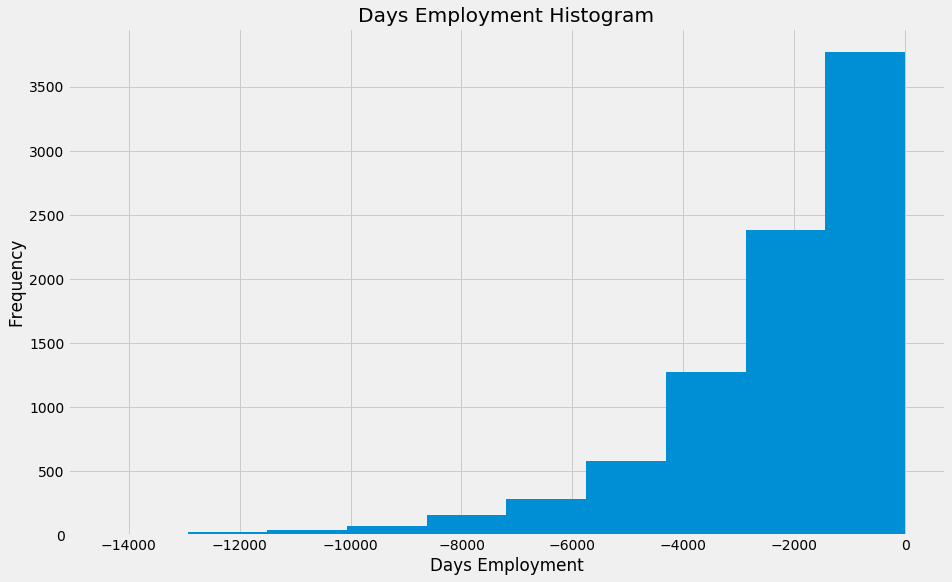

In [72]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

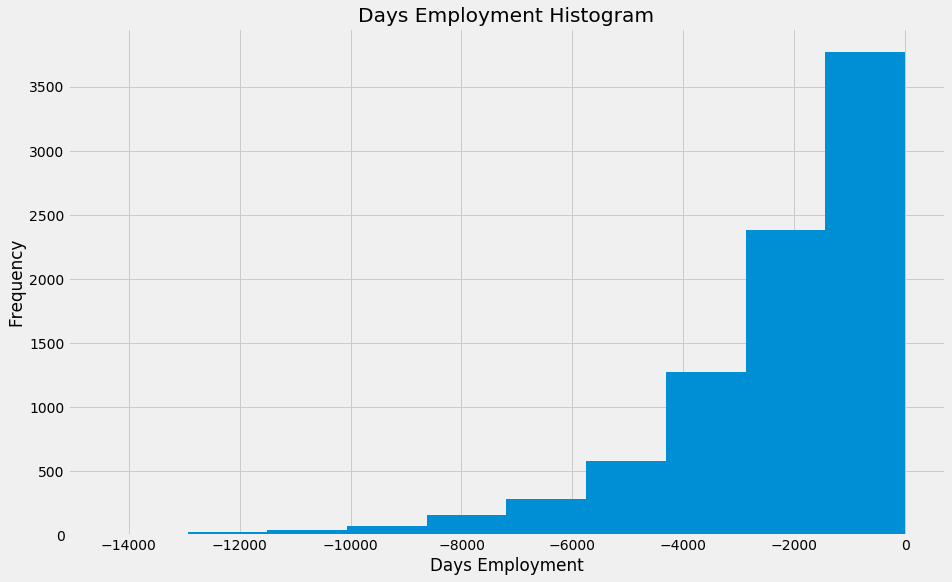

In [73]:
# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [74]:
(train['DAYS_EMPLOYED'] / 365*-1).describe()

count    8602.000000
mean        6.298880
std         5.690901
min         0.010959
25%         2.238356
50%         4.604110
75%         8.582192
max        39.383562
Name: DAYS_EMPLOYED, dtype: float64

In [75]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 123 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [76]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
bool        1
dtype: int64

In [77]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

In [78]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_ID_PUBLISH                0.024877
OWN_CAR_AGE                    0.028052
OBS_60_CNT_SOCIAL_CIRCLE       0.030730
OBS_30_CNT_SOCIAL_CIRCLE       0.031041
AMT_REQ_CREDIT_BUREAU_YEAR     0.033832
DAYS_BIRTH                     0.041108
REGION_RATING_CLIENT           0.053614
FLAG_DOCUMENT_3                0.054269
REGION_RATING_CLIENT_W_CITY    0.061214
DAYS_EMPLOYED                  0.062950
TARGET                         1.000000
FLAG_MOBIL                          NaN
FLAG_DOCUMENT_2                     NaN
FLAG_DOCUMENT_4                     NaN
DAYS_EMPLOYED_ANOM                  NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3           -0.150720
EXT_SOURCE_2           -0.130969
EXT_SOURCE_1           -0.129548
FLOORSMAX_AVG          -0.046110
FLOORSMAX_MODE         -0.045990
FLOORSMAX_MEDI         -0.045206
AMT_INCOME_TOTAL       -0.039762
FLOORSMIN_MEDI         -0.033313
FLOORSMIN_AVG          -0.032904
FLOORSMIN_MODE 

In [79]:
# Join to the training dataframe BureauBalance_by_client
train = train.merge(BureauBalance_by_client, on = 'SK_ID_CURR', how = 'left')
#train.head()
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.00000,0.00000
2,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,1.0,1.0,1.0,1.0,1.0,1.0,0.03125,0.03125,0.03125,0.03125
3,100190,0,Cash loans,M,Y,N,0,162000.0,263686.5,24781.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100295,1,Cash loans,M,Y,N,1,225000.0,1019205.0,31032.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8597,456083,0,Cash loans,F,Y,Y,2,112500.0,361462.5,16051.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8598,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8599,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.00000,0.00000
8600,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 228 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values
client_bureau_balance_MONTHS_BALANCE_count_count,7614,88.5
client_bureau_balance_STATUS_2_count_norm_min,7614,88.5
client_bureau_balance_STATUS_5_count_max,7614,88.5
client_bureau_balance_STATUS_5_count_mean,7614,88.5
client_bureau_balance_STATUS_5_count_count,7614,88.5
client_bureau_balance_STATUS_4_count_norm_sum,7614,88.5
client_bureau_balance_STATUS_4_count_norm_min,7614,88.5
client_bureau_balance_STATUS_4_count_norm_max,7614,88.5
client_bureau_balance_STATUS_4_count_norm_mean,7614,88.5
client_bureau_balance_STATUS_4_count_norm_count,7614,88.5


In [81]:
train.dtypes.value_counts()

float64    170
int64       41
object      16
bool         1
dtype: int64

In [82]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.150720
EXT_SOURCE_2                                      -0.130969
EXT_SOURCE_1                                      -0.129548
client_bureau_balance_MONTHS_BALANCE_count_max    -0.083086
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.079806
                                                     ...   
TARGET                                             1.000000
FLAG_MOBIL                                              NaN
FLAG_DOCUMENT_2                                         NaN
FLAG_DOCUMENT_4                                         NaN
DAYS_EMPLOYED_ANOM                                      NaN
Name: TARGET, Length: 212, dtype: float64

In [83]:
# Join to the training dataframe BureauAgregado_by_loan
train = train.merge(BureauAgregado_by_loan, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,1.0,-740.0,-740.0,-740.0,-740.0,1.0,0.0,0.0,0.0,0.0
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,1.0,-212.0,-212.0,-212.0,-212.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,1.0,-11.0,-11.0,-11.0,-11.0,1.0,0.0,0.0,0.0,0.0
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
train.dtypes.value_counts()

float64    262
int64       41
object      16
bool         1
dtype: int64

In [85]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 320 columns.
There are 197 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_sum,8602,89.7
bureau_DAYS_CREDIT_count,8602,89.7
CREDIT_TYPE_Loan for business development_count_norm,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count_norm,8602,89.7
CREDIT_TYPE_Microloan_count,8602,89.7
CREDIT_TYPE_Microloan_count_norm,8602,89.7
CREDIT_TYPE_Mortgage_count,8602,89.7
CREDIT_TYPE_Mortgage_count_norm,8602,89.7
CREDIT_TYPE_Unknown type of loan_count,8602,89.7


In [86]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.149444
EXT_SOURCE_2                                      -0.131821
EXT_SOURCE_1                                      -0.129646
client_bureau_balance_MONTHS_BALANCE_count_max    -0.083086
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.079806
                                                     ...   
bureau_CREDIT_DAY_OVERDUE_sum                           NaN
bureau_AMT_CREDIT_SUM_OVERDUE_mean                      NaN
bureau_AMT_CREDIT_SUM_OVERDUE_max                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_min                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_sum                       NaN
Name: TARGET, Length: 304, dtype: float64

In [87]:
# Join to the training dataframe installments_payments_by_client
train = train.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,154110.600,352394.100,285724.440,297639.540,346218.795,358133.895,358630.650,358630.650,7.748055e+06,8.045932e+06
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,1165942.125,1165942.125,794145.870,794145.870,1734972.210,1734972.210,6344576.280,6344576.280,3.596996e+07,3.596996e+07
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,1165942.125,1165942.125,794145.870,794145.870,1734972.210,1734972.210,6344576.280,6344576.280,3.596996e+07,3.596996e+07
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,44754.255,2432587.725,1061276.535,1768442.940,1990843.425,3052545.795,3087889.965,3087889.965,4.668938e+07,7.398267e+07
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,44754.255,2432587.725,1061276.535,1768442.940,1990843.425,3052545.795,3087889.965,3087889.965,4.668938e+07,7.398267e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,54177.705,54177.705,32872.995,32872.995,65484.540,65484.540,128968.875,128968.875,4.252573e+05,4.252573e+05
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,472205.610,472205.610,423378.720,423378.720,504632.745,504632.745,926185.500,926185.500,4.524586e+06,4.524586e+06
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,472205.610,472205.610,423378.720,423378.720,504632.745,504632.745,926185.500,926185.500,4.524586e+06,4.524586e+06
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,321518.115,321518.115,123710.625,123710.625,350466.705,350466.705,450696.195,450696.195,2.261266e+06,2.261266e+06


In [88]:
train.dtypes.value_counts()

float64    363
int64       41
object      16
bool         1
dtype: int64

In [89]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 421 columns.
There are 298 columns that have missing values.


,Missing Values,% of Total Values
bureau_DAYS_CREDIT_ENDDATE_max,8602,89.7
bureau_DAYS_CREDIT_count,8602,89.7
CREDIT_TYPE_Loan for business development_count_norm,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count_norm,8602,89.7
CREDIT_TYPE_Microloan_count,8602,89.7
CREDIT_TYPE_Microloan_count_norm,8602,89.7
CREDIT_TYPE_Mortgage_count,8602,89.7
CREDIT_TYPE_Mortgage_count_norm,8602,89.7
CREDIT_TYPE_Unknown type of loan_count,8602,89.7


In [90]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.149444
EXT_SOURCE_2                                      -0.131821
EXT_SOURCE_1                                      -0.129646
client_bureau_balance_MONTHS_BALANCE_count_max    -0.083086
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.079806
                                                     ...   
bureau_CREDIT_DAY_OVERDUE_sum                           NaN
bureau_AMT_CREDIT_SUM_OVERDUE_mean                      NaN
bureau_AMT_CREDIT_SUM_OVERDUE_max                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_min                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_sum                       NaN
Name: TARGET, Length: 405, dtype: float64

In [91]:
# Join to the training dataframe POS_CASH_balance_by_client
train = train.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_cash_SK_DPD_DEF_sum_sum,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,0.0,0.0,0.0,686.0,686.0,686.0,686.0,697.0,7441.0,15034.0
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,0.0,0.0,0.0,1574.0,1574.0,1861.0,1902.0,1042.0,26768.0,39842.0
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,0.0,0.0,0.0,1574.0,1574.0,1861.0,1902.0,1042.0,26768.0,39842.0
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,278.0,207.0,278.0,696.0,696.0,696.0,696.0,748.0,5295.0,10848.0
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,278.0,207.0,278.0,696.0,696.0,696.0,696.0,748.0,5295.0,10848.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,0.0,0.0,0.0,102.0,102.0,102.0,102.0,117.0,414.0,828.0
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,0.0,0.0,0.0,456.0,306.0,436.0,456.0,289.0,4024.0,5868.0
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,0.0,0.0,0.0,456.0,306.0,436.0,456.0,289.0,4024.0,5868.0
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,0.0,0.0,0.0,360.0,342.0,359.0,378.0,360.0,1588.0,3174.0


In [92]:
train.dtypes.value_counts()

float64    448
int64       41
object      16
bool         1
dtype: int64

In [93]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 506 columns.
There are 383 columns that have missing values.


,Missing Values,% of Total Values
bureau_DAYS_CREDIT_UPDATE_sum,8602,89.7
bureau_DAYS_CREDIT_mean,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count_norm,8602,89.7
CREDIT_TYPE_Microloan_count,8602,89.7
CREDIT_TYPE_Microloan_count_norm,8602,89.7
CREDIT_TYPE_Mortgage_count,8602,89.7
CREDIT_TYPE_Mortgage_count_norm,8602,89.7
CREDIT_TYPE_Unknown type of loan_count,8602,89.7
CREDIT_TYPE_Unknown type of loan_count_norm,8602,89.7


In [94]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.149444
EXT_SOURCE_2                                      -0.131821
EXT_SOURCE_1                                      -0.129646
client_bureau_balance_MONTHS_BALANCE_count_max    -0.083086
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.079806
                                                     ...   
bureau_AMT_CREDIT_SUM_OVERDUE_mean                      NaN
bureau_AMT_CREDIT_SUM_OVERDUE_max                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_min                       NaN
bureau_AMT_CREDIT_SUM_OVERDUE_sum                       NaN
client_cash_SK_DPD_DEF_min_min                          NaN
Name: TARGET, Length: 490, dtype: float64

In [95]:
# Join to the training dataframe credit_card_balance_by_client
train = train.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_credit_AMT_TOTAL_RECEIVABLE_max_sum,client_credit_AMT_BALANCE_max_sum,client_credit_AMT_INST_MIN_REGULARITY_sum_sum,client_credit_AMT_PAYMENT_TOTAL_CURRENT_sum_sum,client_credit_AMT_PAYMENT_CURRENT_sum_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum,client_credit_AMT_RECIVABLE_sum_sum,client_credit_AMT_TOTAL_RECEIVABLE_sum_sum,client_credit_AMT_BALANCE_sum_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,4017803.04,4017803.04,2345258.88,4950218.88,7546996.8,14243096.16,14634194.4,14634194.4,14878585.44,168480000.0
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,4017803.04,4017803.04,2345258.88,4950218.88,7546996.8,14243096.16,14634194.4,14634194.4,14878585.44,168480000.0
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
train.dtypes.value_counts()

float64    763
int64       41
object      16
bool         1
dtype: int64

In [97]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 821 columns.
There are 698 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_CREDIT_MAX_OVERDUE_min,8602,89.7
bureau_DAYS_CREDIT_mean,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count,8602,89.7
CREDIT_TYPE_Loan for working capital replenishment_count_norm,8602,89.7
CREDIT_TYPE_Microloan_count,8602,89.7
CREDIT_TYPE_Microloan_count_norm,8602,89.7
CREDIT_TYPE_Mortgage_count,8602,89.7
CREDIT_TYPE_Mortgage_count_norm,8602,89.7
CREDIT_TYPE_Unknown type of loan_count,8602,89.7
CREDIT_TYPE_Unknown type of loan_count_norm,8602,89.7


In [98]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                     -0.149444
EXT_SOURCE_2                                     -0.131821
EXT_SOURCE_1                                     -0.129646
client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum    -0.093719
client_bureau_balance_MONTHS_BALANCE_count_max   -0.083086
                                                    ...   
client_cash_SK_DPD_DEF_min_min                         NaN
client_credit_SK_DPD_DEF_min_mean                      NaN
client_credit_SK_DPD_DEF_min_sum                       NaN
client_credit_SK_DPD_min_mean                          NaN
client_credit_SK_DPD_min_sum                           NaN
Name: TARGET, Length: 805, dtype: float64

In [99]:
# Join to the training dataframe previous_application_ag
train = train.merge(previous_application_ag, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
train.dtypes.value_counts()

float64    809
int64       41
object      16
float32     14
bool         1
dtype: int64

In [101]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 881 columns.
There are 758 columns that have missing values.


,Missing Values,% of Total Values
previous_NAME_CONTRACT_TYPE_Cash loans_count,9590,100.0
previous_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Audio/Video_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Medical Supplies_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Tourism_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Consumer Electronics_sum,9590,100.0
previous_NAME_TYPE_SUITE_Other_B_sum,9590,100.0
previous_NAME_SELLER_INDUSTRY_Tourism_sum,9590,100.0
previous_WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,9590,100.0
previous_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_sum,9590,100.0


In [102]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                     -0.149444
EXT_SOURCE_2                                     -0.131821
EXT_SOURCE_1                                     -0.129646
client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum    -0.093719
client_bureau_balance_MONTHS_BALANCE_count_max   -0.083086
                                                    ...   
previous_NAME_GOODS_CATEGORY_Mobile_sum                NaN
previous_NAME_TYPE_SUITE_Unaccompanied_sum             NaN
previous_NAME_SELLER_INDUSTRY_Connectivity_sum         NaN
previous_CHANNEL_TYPE_Country-wide_sum                 NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count           NaN
Name: TARGET, Length: 865, dtype: float64

In [103]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 previous_CHANNEL_TYPE_Stone_sum                               NaN
previous_PRODUCT_COMBINATION_POS industry with interest_sum   NaN
previous_NAME_CLIENT_TYPE_XNA_sum                             NaN
previous_NAME_TYPE_SUITE_Family_sum                           NaN
previous_NAME_GOODS_CATEGORY_Computers_sum                    NaN
previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum              NaN
previous_NAME_PAYMENT_TYPE_Cash through the bank_sum          NaN
previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum                NaN
previous_NAME_PAYMENT_TYPE_XNA_sum                            NaN
previous_NAME_CLIENT_TYPE_Refreshed_sum                       NaN
previous_NAME_GOODS_CATEGORY_Mobile_sum                       NaN
previous_NAME_TYPE_SUITE_Unaccompanied_sum                    NaN
previous_NAME_SELLER_INDUSTRY_Connectivity_sum                NaN
previous_CHANNEL_TYPE_Country-wide_sum                        NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count   

In [104]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_TYPE_SUITE_Unaccompanied_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,456084,0,Cash loans,F,Y,Y,1,99000.0,675000.0,21906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9586,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,456140,1,Cash loans,F,Y,Y,1,261000.0,711454.5,47673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9588,456195,0,Cash loans,F,Y,Y,0,94500.0,270000.0,15075.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [106]:
#8-Cargo fichero application_test.csv y veo cabecera
test = pd.read_csv('/Users/LENOVO/Downloads/application_test.csv', delimiter= ',' , header=0)
test = test.dropna()
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
15,100107,Cash loans,M,Y,Y,0,180000.0,296280.0,21690.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
18,100128,Cash loans,F,Y,Y,1,225000.0,431280.0,23526.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,4.0
73,100561,Cash loans,M,Y,Y,0,180000.0,67500.0,8140.5,67500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
86,100699,Cash loans,M,Y,Y,1,225000.0,323460.0,23134.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
102,100770,Cash loans,M,Y,N,0,202500.0,697500.0,33687.0,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48628,455243,Cash loans,F,Y,Y,1,112500.0,252531.0,26005.5,234000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
48670,455607,Cash loans,M,Y,Y,0,387000.0,350415.0,25051.5,292500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
48682,455703,Cash loans,F,Y,Y,1,450000.0,790830.0,57676.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48707,455940,Cash loans,M,Y,Y,0,202500.0,225000.0,19242.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0


In [107]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

There are 0 anomalies in the test data out of 1739 entries


In [108]:
test.dtypes.value_counts()

float64    65
int64      40
object     16
bool        1
dtype: int64

In [109]:
missing_values = missing_values_table(test)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [110]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

In [111]:
# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

5 columns were label encoded.


In [112]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test  = pd.get_dummies(test )

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (9590, 990)
Testing Features shape:  (1739, 229)


In [113]:
#Alineamos set de datos
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (9590, 229)
Testing Features shape:  (1739, 228)


In [114]:
#Función para eliminar variables colineales
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
#corr_matrix.head()
corr_matrix

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
SK_ID_CURR,1.000000,0.008575,0.013943,NaN,0.005278,0.005066,0.011009,0.012280,0.029963,0.014715,...,0.010672,0.025292,0.018855,0.003493,0.016484,0.023249,0.013228,0.000434,0.007198,0.020304
NAME_CONTRACT_TYPE,0.008575,1.000000,0.001639,NaN,0.071921,0.019699,0.028713,0.234214,0.262251,0.200086,...,0.025521,0.006107,0.010262,0.011194,0.002221,0.002266,0.017576,0.014144,0.013803,0.043676
CODE_GENDER,0.013943,0.001639,1.000000,NaN,0.052692,0.020956,0.101930,0.037113,0.002879,0.036434,...,0.013469,0.001224,0.014884,0.000858,0.006185,0.016164,0.022401,0.010651,0.002437,0.032292
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0.005278,0.071921,0.052692,NaN,1.000000,0.030509,0.001466,0.041198,0.012320,0.047228,...,0.001950,0.003812,0.002599,0.006694,0.008960,0.009034,0.011244,0.014166,0.004127,0.004546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALLSMATERIAL_MODE_Others,0.023249,0.002266,0.016164,NaN,0.009034,0.014486,0.006623,0.012755,0.016784,0.016225,...,0.008519,0.030118,0.028939,0.012244,0.014396,1.000000,0.105600,0.089445,0.015064,0.000299
WALLSMATERIAL_MODE_Panel,0.013228,0.017576,0.022401,NaN,0.011244,0.003694,0.030331,0.020976,0.028763,0.020303,...,0.041531,0.058182,0.251784,0.106525,0.125251,0.105600,1.000000,0.778218,0.131061,0.010868
"WALLSMATERIAL_MODE_Stone, brick",0.000434,0.014144,0.010651,NaN,0.014166,0.006518,0.064809,0.033981,0.048455,0.031799,...,0.045340,0.018643,0.213267,0.090229,0.106091,0.089445,0.778218,1.000000,0.111011,0.019155
WALLSMATERIAL_MODE_Wooden,0.007198,0.013803,0.002437,NaN,0.004127,0.006002,0.001572,0.023849,0.008859,0.026695,...,0.009641,0.052005,0.035917,0.015196,0.017867,0.015064,0.131061,0.111011,1.000000,0.007023


In [115]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#upper.head()
upper

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
SK_ID_CURR,NaN,0.008575,0.013943,NaN,0.005278,0.005066,0.011009,0.012280,0.029963,0.014715,...,0.010672,0.025292,0.018855,0.003493,0.016484,0.023249,0.013228,0.000434,0.007198,0.020304
NAME_CONTRACT_TYPE,NaN,NaN,0.001639,NaN,0.071921,0.019699,0.028713,0.234214,0.262251,0.200086,...,0.025521,0.006107,0.010262,0.011194,0.002221,0.002266,0.017576,0.014144,0.013803,0.043676
CODE_GENDER,NaN,NaN,NaN,NaN,0.052692,0.020956,0.101930,0.037113,0.002879,0.036434,...,0.013469,0.001224,0.014884,0.000858,0.006185,0.016164,0.022401,0.010651,0.002437,0.032292
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,NaN,0.030509,0.001466,0.041198,0.012320,0.047228,...,0.001950,0.003812,0.002599,0.006694,0.008960,0.009034,0.011244,0.014166,0.004127,0.004546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALLSMATERIAL_MODE_Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.105600,0.089445,0.015064,0.000299
WALLSMATERIAL_MODE_Panel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778218,0.131061,0.010868
"WALLSMATERIAL_MODE_Stone, brick",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111011,0.019155
WALLSMATERIAL_MODE_Wooden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007023


In [116]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 35 columns to remove.


In [117]:
to_drop

['AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

In [118]:
#Elimino variables colineales
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (9590, 194)
Testing shape:  (1739, 193)


In [119]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.149444
EXT_SOURCE_2                           -0.131821
EXT_SOURCE_1                           -0.129646
NAME_EDUCATION_TYPE_Higher education   -0.054774
NAME_CONTRACT_TYPE                     -0.043676
                                          ...   
FLAG_OWN_CAR                                 NaN
FLAG_MOBIL                                   NaN
FLAG_DOCUMENT_2                              NaN
FLAG_DOCUMENT_4                              NaN
DAYS_EMPLOYED_ANOM                           NaN
Name: TARGET, Length: 194, dtype: float64

In [120]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 NAME_HOUSING_TYPE_With parents         0.030194
CODE_GENDER                            0.032292
AMT_REQ_CREDIT_BUREAU_YEAR             0.033083
ORGANIZATION_TYPE_Transport: type 3    0.034979
OCCUPATION_TYPE_Laborers               0.038861
DAYS_BIRTH                             0.042169
REGION_RATING_CLIENT                   0.049486
FLAG_DOCUMENT_3                        0.054571
DAYS_EMPLOYED                          0.063844
TARGET                                 1.000000
FLAG_OWN_CAR                                NaN
FLAG_MOBIL                                  NaN
FLAG_DOCUMENT_2                             NaN
FLAG_DOCUMENT_4                             NaN
DAYS_EMPLOYED_ANOM                          NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.149444
EXT_SOURCE_2                           -0.131821
EXT_SOURCE_1                           -0.129646
NAME_EDUCATION_TYPE_Higher education   -0.054

In [121]:
train.shape


(9590, 194)

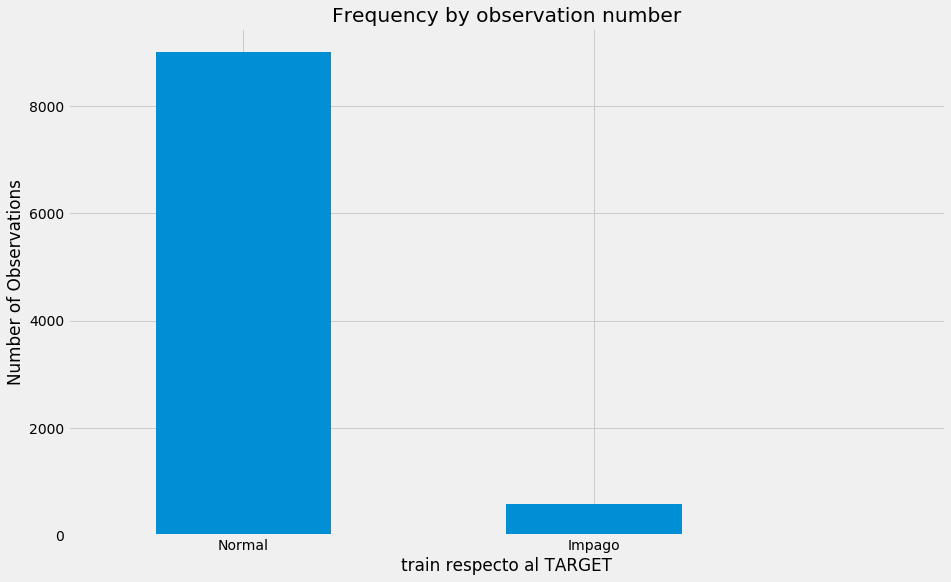

In [122]:
#El gráfico nos  muestra nuestro dataset esta desbalanceado 
count_classes = pd.value_counts(train['TARGET'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(3), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("train respecto al TARGET")
plt.ylabel("Number of Observations");

In [123]:
#Creamos Dataset de train
normal_df = train[train.TARGET == 0] #registros normales
impago_df = train[train.TARGET == 1] #casos de impago

In [124]:
normal_df.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
count,9000.000000,9000.000000,9000.000000,9000.0,9000.000000,9000.000000,9.000000e+03,9.000000e+03,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.0
mean,277930.985333,0.101556,0.504000,0.0,0.689556,0.605778,2.242129e+05,7.018143e+05,31842.664500,0.023464,...,0.005556,0.005556,0.064778,0.012556,0.017444,0.012000,0.480222,0.394889,0.018111,0.0
std,103344.785699,0.302080,0.500012,0.0,0.462701,0.779167,1.406989e+05,4.668230e+05,16663.377432,0.016388,...,0.074332,0.074332,0.246147,0.111352,0.130928,0.108891,0.499636,0.488854,0.133361,0.0
min,100083.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.375000e+04,4.500000e+04,2317.500000,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,187647.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.350000e+05,3.141000e+05,19867.500000,0.010556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,275847.000000,0.000000,1.000000,0.0,1.000000,0.000000,2.025000e+05,5.903370e+05,29333.250000,0.020246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,369651.000000,0.000000,1.000000,0.0,1.000000,1.000000,2.700000e+05,9.611460e+05,40702.500000,0.030755,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,456226.000000,1.000000,1.000000,0.0,1.000000,5.000000,4.500000e+06,4.050000e+06,225000.000000,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [125]:
#normal_df.EXT_SOURCE_3

In [126]:
impago_df.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,TARGET
count,590.000000,590.000000,590.000000,590.0,590.000000,590.000000,5.900000e+02,5.900000e+02,590.000000,590.000000,...,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.0
mean,286664.677966,0.047458,0.571186,0.0,0.698305,0.549153,2.004014e+05,6.685776e+05,31636.022034,0.022549,...,0.011864,0.006780,0.061017,0.006780,0.006780,0.011864,0.457627,0.433898,0.022034,1.0
std,103385.562730,0.212796,0.495326,0.0,0.459383,0.727900,1.040374e+05,4.158467e+05,14344.133825,0.014002,...,0.108368,0.082129,0.239565,0.082129,0.082129,0.108368,0.498624,0.496032,0.146918,0.0
min,100295.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.985000e+04,5.094000e+04,3559.500000,0.001276,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,198244.750000,0.000000,0.000000,0.0,0.000000,0.000000,1.350000e+05,3.612240e+05,21613.500000,0.011657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,295855.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.800000e+05,5.450400e+05,30332.250000,0.020246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,374969.750000,0.000000,1.000000,0.0,1.000000,1.000000,2.250000e+05,8.542721e+05,39969.000000,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0
max,456140.000000,1.000000,1.000000,0.0,1.000000,3.000000,1.170000e+06,2.695500e+06,85869.000000,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [127]:
#impago_df.EXT_SOURCE_3

In [128]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Text(0.5, 1.0, 'Number of observations per class')

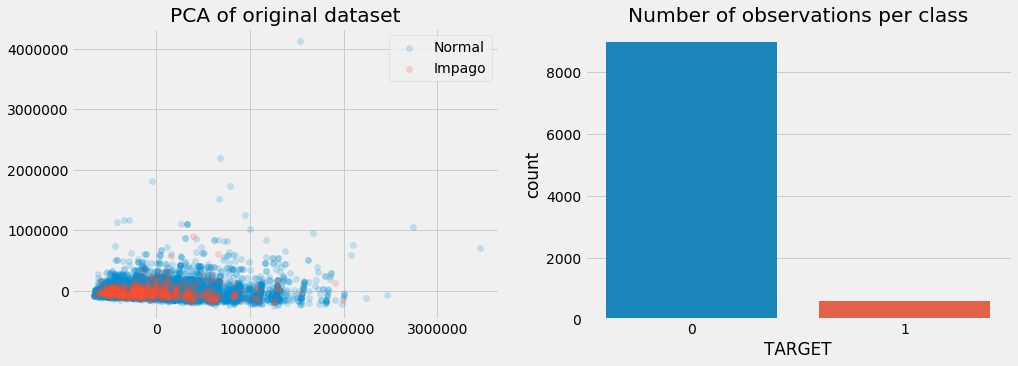

In [129]:
# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Impago", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sn.countplot(y)
ax[1].set_title('Number of observations per class')

In [130]:
#Función para mostrar grafico de resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sn.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True TARGET')
    plt.xlabel('Predicted TARGET')
    plt.show()
    print (classification_report(y_test, pred_y))

In [131]:
#Parametros grafico
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Impago"]

In [132]:
#1-Ejecutamos Modelo con LogisticRegresion sin balancear
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

In [133]:
#Modelo 
model = run_model(X_train, X_test, y_train, y_test)

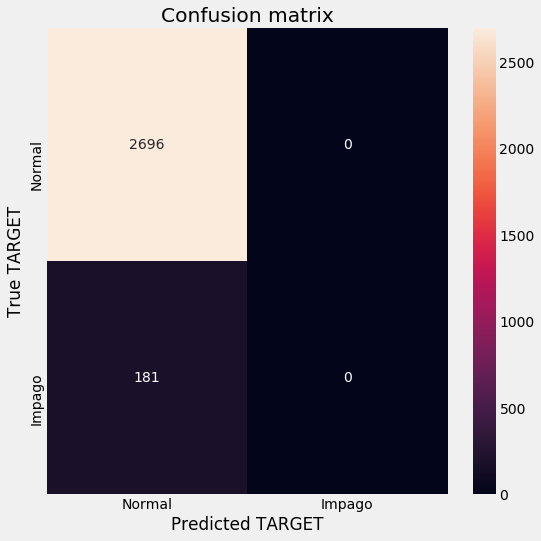

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2696
           1       0.00      0.00      0.00       181

    accuracy                           0.94      2877
   macro avg       0.47      0.50      0.48      2877
weighted avg       0.88      0.94      0.91      2877



In [134]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [135]:
#2- Ejecutamos Modelo con LogisticRegresion balanceando el set de datos class_weight="balanced"
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

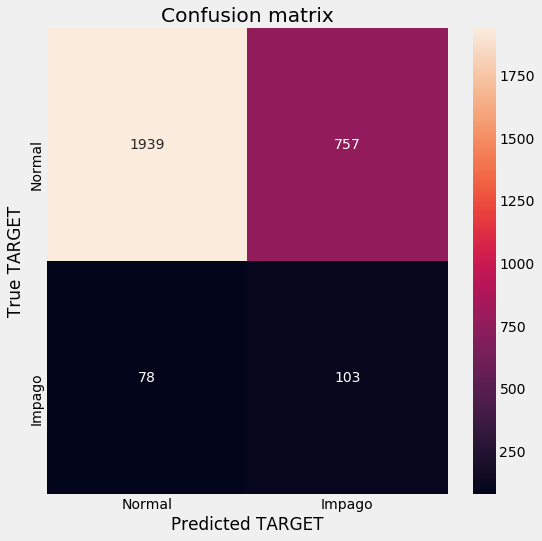

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      2696
           1       0.12      0.57      0.20       181

    accuracy                           0.71      2877
   macro avg       0.54      0.64      0.51      2877
weighted avg       0.91      0.71      0.78      2877



In [136]:
#Probamos como responde en el test set
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [137]:
#3- Probamos con Random Forest

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


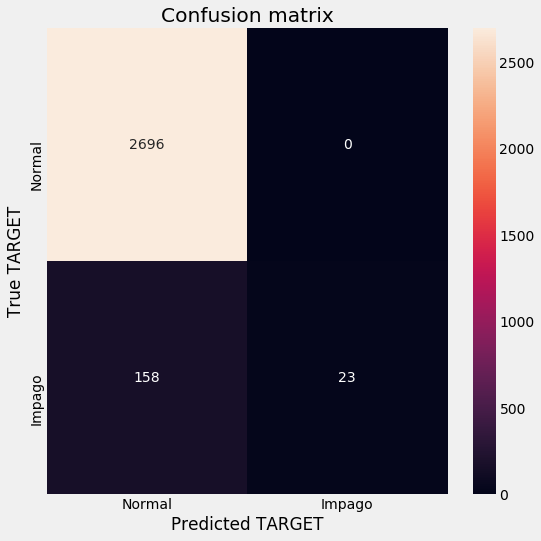

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2696
           1       1.00      0.13      0.23       181

    accuracy                           0.95      2877
   macro avg       0.97      0.56      0.60      2877
weighted avg       0.95      0.95      0.92      2877



In [138]:
#Revisamos los resultados
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [139]:
#4- Modelo RandomForestClassifier variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


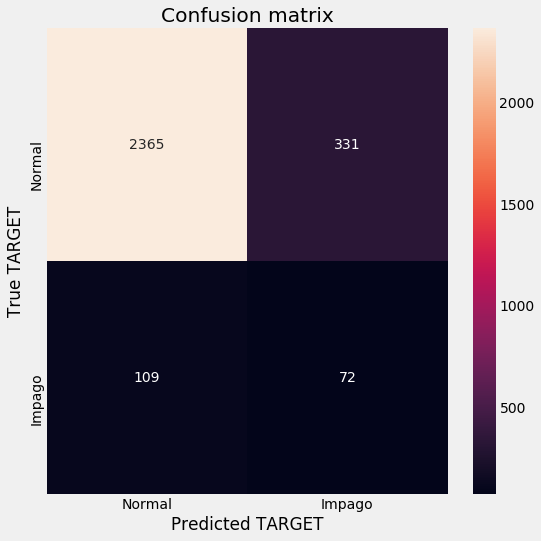

              precision    recall  f1-score   support

           0       0.96      0.88      0.91      2696
           1       0.18      0.40      0.25       181

    accuracy                           0.85      2877
   macro avg       0.57      0.64      0.58      2877
weighted avg       0.91      0.85      0.87      2877



In [140]:
#Vemos la Confusion Matrix con el conjunto de Test
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [141]:
#df = pd.DataFrame({'algorithm' : ['LogisticRegresion sin balancear', 'LogisticRegresion balanceado', 'Random Forest',
#                                 'RandomForestClassifier'],
#                   'precision' : [0, 0.12, 1.0, 0.16],
#                   'recall' : [0, 0.68, 0.12, 0.38]})

#df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

#df = df.sort_values(['overall'], ascending=True)
#df

In [142]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [143]:
print(roc_value)

0.6375077872682262
